In [6]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Navier-Stokes equation discussed in Section 5.3 in the [paper](https://arxiv.org/pdf/2010.08895.pdf),
which uses a recurrent structure to propagates in time.
"""
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import os

torch.manual_seed(0)
np.random.seed(0)

In [7]:
# 手动复数乘法：输入和输出都是实虚分离格式 (..., 2)
# def compl_mul2d(a, b):
#     # a, b: [..., 2], 表示复数 a = a[..., 0] + i * a[..., 1]
#     re = torch.einsum("bixy, iojy -> bojxy", a[..., 0], b[..., 0]) - torch.einsum("bixy, iojy -> bojxy", a[..., 1], b[..., 1])
#     im = torch.einsum("bixy, iojy -> bojxy", a[..., 1], b[..., 0]) + torch.einsum("bixy, iojy -> bojxy", a[..., 0], b[..., 1])
#     return torch.stack([re, im], dim=-1)

def compl_mul2d(a, b):
    re = torch.einsum("bixy, ioxy -> boxy", a[..., 0], b[..., 0]) - \
         torch.einsum("bixy, ioxy -> boxy", a[..., 1], b[..., 1])
    im = torch.einsum("bixy, ioxy -> boxy", a[..., 1], b[..., 0]) + \
         torch.einsum("bixy, ioxy -> boxy", a[..., 0], b[..., 1])
    return torch.stack([re, im], dim=-1)

In [8]:
class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))**0.5
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, 2))
        self.weights2 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, 2))

    def forward(self, x):
        B, C, H, W = x.shape

        # 1. 实数输入 → 复数频域 (complex tensor)
        x_ft = torch.fft.rfft2(x, norm="ortho")  # shape: [B, C, H, W//2+1], dtype=torch.cfloat

        # 2. 拆分实虚部（为了与 weights 的 [real, imag] 匹配）
        x_ft_split = torch.stack([x_ft.real, x_ft.imag], dim=-1)  # shape: [B, C, H, W//2+1, 2]

        # 3. 初始化输出频域（实虚分离）
        out_ft = torch.zeros(B, self.out_channels, H, W // 2 + 1, 2, device=x.device)
        # print("x_ft_split[:, :, :m1, :m2] shape:", x_ft_split[:, :, :self.modes1, :self.modes2].shape)
        # print("weights1 shape:", self.weights1.shape)
        # 4. 频域复数乘法
        out_ft[:, :, :self.modes1, :self.modes2] = compl_mul2d(
            x_ft_split[:, :, :self.modes1, :self.modes2], self.weights1
        )
        out_ft[:, :, -self.modes1:, :self.modes2] = compl_mul2d(
            x_ft_split[:, :, -self.modes1:, :self.modes2], self.weights2
        )

        # 5. 组合成复数格式，用于 irfft2
        out_ft_complex = torch.complex(out_ft[..., 0], out_ft[..., 1])  # shape: [B, C, H, W//2+1]

        # 6. 频域 → 实空间
        x = torch.fft.irfft2(out_ft_complex, s=(H, W), norm="ortho")
        return x
class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(SimpleBlock2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(12, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        #对应着上图(a)里的四个傅里叶层
        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        #对应着上图(b)里的w，类似ResNet的Shortcut连接
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        #经过Forier layer0
        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn0(x1 + x2)
        x = F.relu(x)
        
        #经过Forier layer1
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn1(x1 + x2)
        x = F.relu(x)
        
        #经过Forier layer2
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn2(x1 + x2)
        x = F.relu(x)
        
        #经过Forier layer3
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn3(x1 + x2)

        # 经过两个全连接层，将channel维度映射到目标输出的维度
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net2d(nn.Module):
    def __init__(self, modes, width):
        super(Net2d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock2d(modes, modes, width)


    def forward(self, x):
        x = self.conv1(x)
        return x


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [9]:
################################################################
# configs
################################################################
TRAIN_PATH = '/home/yc/FNO/data/NavierStokes_V1e-5_N1200_T20.mat'
TEST_PATH = '/home/yc/FNO/data/NavierStokes_V1e-5_N1200_T20.mat'

ntrain = 1000
ntest = 200

modes = 12
width = 20

batch_size = 20
batch_size2 = batch_size

epochs = 500
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

# 确保所有目录存在
os.makedirs('model', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('image', exist_ok=True)
os.makedirs('pred', exist_ok=True)
os.makedirs('vis', exist_ok=True)

path = 'ns_fourier_2d_rnn_V1e-5_T20_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

# 确保特定实验目录存在
os.makedirs(os.path.dirname(path_model), exist_ok=True)
os.makedirs(os.path.dirname(path_train_err), exist_ok=True)
os.makedirs(os.path.dirname(path_test_err), exist_ok=True)
os.makedirs(path_image, exist_ok=True)

runtime = np.zeros(2, )
t1 = default_timer()
#sub用于下采样分辨率
sub = 1
#分辨率设置，该数据集是64*64
S = 64
T_in = 10
T = 10
step = 1

500 0.0025 100 0.5


In [10]:
################################################################
# load data
################################################################
#仅用到了数据集中的u,分别将[0,10]作为输入，[10,20]作为输出的label
#训练输入：前T_in个时间步的解，训练输出：接下来的T个时间步的解
reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]
reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

print(train_u.shape)#[1000,64,64,10]
print(test_u.shape)#[200,64,64,10]
#检查这两个维度是否与设定的一致
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = train_a.reshape(ntrain,S,S,T_in)
test_a = test_a.reshape(ntest,S,S,T_in)

# pad the location (x,y)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1).repeat([1, 1, S, 1])
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1).repeat([1, S, 1, 1])
#沿最后一个维度进行拼接，[ntrain, S, S, T_in+2],位置编码
train_a = torch.cat((train_a, gridx.repeat([ntrain,1,1,1]), gridy.repeat([ntrain,1,1,1])), dim=-1)
test_a = torch.cat((test_a, gridx.repeat([ntest,1,1,1]), gridy.repeat([ntest,1,1,1])), dim=-1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')

torch.Size([1000, 64, 64, 10])
torch.Size([200, 64, 64, 10])
preprocessing finished, time used: 0.7579275406897068


In [11]:
################################################################
# training and evaluation
################################################################

model = Net2d(modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print(model.count_params())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


myloss = LpLoss(size_average=False)
gridx = gridx.to(device)
gridy = gridy.to(device)

# 存储训练历史
train_losses = []
test_losses = []
times = []

print("开始训练...")
print("Epoch | Time | Train Loss (Step) | Train Loss (Full) | Test Loss (Step) | Test Loss (Full)")
print("-" * 90)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        #xx是input，yy是label，及对应前面的train_a和train_u
        xx = xx.to(device)
        yy = yy.to(device)
        # 这里需要注意的是，对t在[10,20）的输出方式是滚动的
        # 即输入T[0,10)，输出T[10]，得到T[10]后，下一轮输入T[0,11)，输出T[11]
        # 每次只输出一个时间点的结果，输入该时间点之前的所有结果
        for t in range(0, T, step):
            #这里指具体时间点label的值
            y = yy[..., t:t + step]
            im = model(xx)
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))
            ## 如果t=0则模型输出直接等于pred，如果不为0，则把本次输出和之前的输出拼接起来，即把每个时间点的输出拼起来
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)
            #将本次输出的im拼接到xx上，用作下一轮的输入
            xx = torch.cat((xx[..., step:-2], im,
                            gridx.repeat([batch_size, 1, 1, 1]), gridy.repeat([batch_size, 1, 1, 1])), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        # l2_full.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat((xx[..., step:-2], im,
                                gridx.repeat([batch_size, 1, 1, 1]), gridy.repeat([batch_size, 1, 1, 1])), dim=-1)


            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()

    t2 = default_timer()
    scheduler.step()
    
    # 计算平均损失
    train_step_avg = train_l2_step / ntrain / (T / step)
    train_full_avg = train_l2_full / ntrain
    test_step_avg = test_l2_step / ntest / (T / step)
    test_full_avg = test_l2_full / ntest
    
    # 记录历史
    train_losses.append((train_step_avg, train_full_avg))
    test_losses.append((test_step_avg, test_full_avg))
    times.append(t2 - t1)
    
    # 打印进度
    if ep % 10 == 0 or ep < 10:
        print(f"{ep:4d} | {t2-t1:4.1f}s | {train_step_avg:.6f} | {train_full_avg:.6f} | {test_step_avg:.6f} | {test_full_avg:.6f}")

print("\n训练完成！")
torch.save(model, path_model)

926517
开始训练...
Epoch | Time | Train Loss (Step) | Train Loss (Full) | Test Loss (Step) | Test Loss (Full)
------------------------------------------------------------------------------------------
开始训练...
Epoch | Time | Train Loss (Step) | Train Loss (Full) | Test Loss (Step) | Test Loss (Full)
------------------------------------------------------------------------------------------
   0 | 10.0s | 0.413165 | 0.448452 | 0.293046 | 0.331283
   0 | 10.0s | 0.413165 | 0.448452 | 0.293046 | 0.331283
   1 |  9.7s | 0.270592 | 0.308562 | 0.246620 | 0.282618
   1 |  9.7s | 0.270592 | 0.308562 | 0.246620 | 0.282618
   2 |  9.5s | 0.235280 | 0.270852 | 0.236388 | 0.269748
   2 |  9.5s | 0.235280 | 0.270852 | 0.236388 | 0.269748
   3 |  9.5s | 0.221137 | 0.256698 | 0.250087 | 0.287533
   3 |  9.5s | 0.221137 | 0.256698 | 0.250087 | 0.287533
   4 |  9.3s | 0.219911 | 0.255706 | 0.212290 | 0.243685
   4 |  9.3s | 0.219911 | 0.255706 | 0.212290 | 0.243685
   5 |  8.9s | 0.201700 | 0.234625 | 0.2121

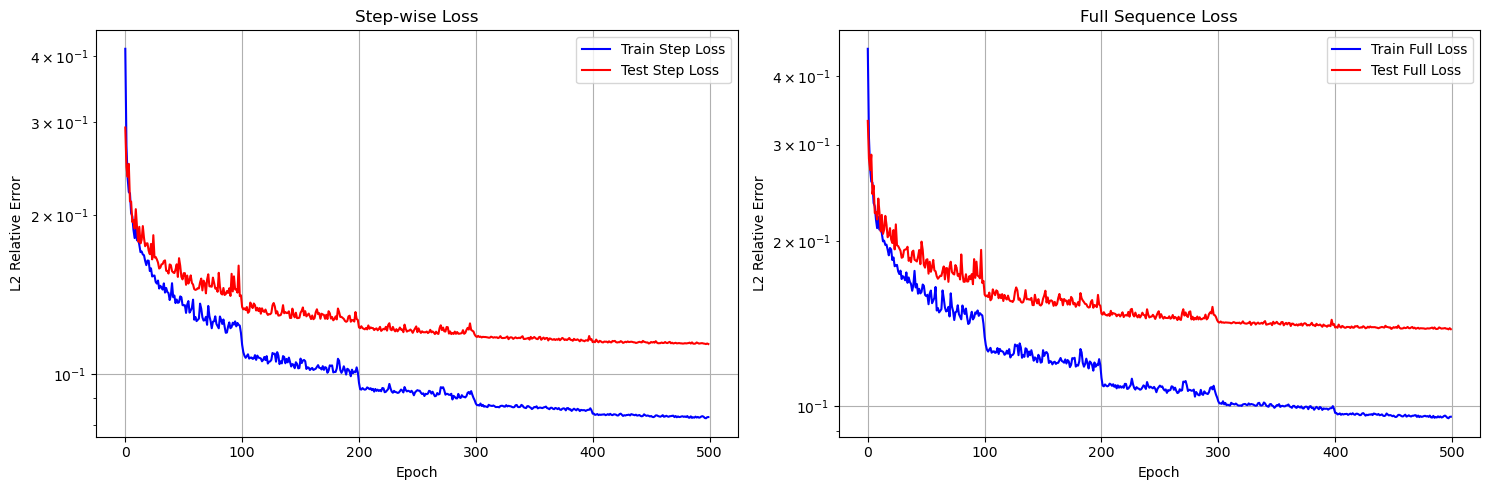


最终结果:
训练步进损失: 0.082841
训练全序列损失: 0.095674
测试步进损失: 0.113929
测试全序列损失: 0.138178
平均训练时间: 9.77 秒/epoch


In [12]:
################################################################
# 结果可视化
################################################################

# 提取损失数据
train_step_losses = [loss[0] for loss in train_losses]
train_full_losses = [loss[1] for loss in train_losses]
test_step_losses = [loss[0] for loss in test_losses]
test_full_losses = [loss[1] for loss in test_losses]

# 绘制损失曲线
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 步进损失
ax1.plot(train_step_losses, label='Train Step Loss', color='blue')
ax1.plot(test_step_losses, label='Test Step Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Relative Error')
ax1.set_title('Step-wise Loss')
ax1.legend()
ax1.grid(True)
ax1.set_yscale('log')

# 全序列损失
ax2.plot(train_full_losses, label='Train Full Loss', color='blue')
ax2.plot(test_full_losses, label='Test Full Loss', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('L2 Relative Error')
ax2.set_title('Full Sequence Loss')
ax2.legend()
ax2.grid(True)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# 打印最终结果
print(f"\n最终结果:")
print(f"训练步进损失: {train_step_losses[-1]:.6f}")
print(f"训练全序列损失: {train_full_losses[-1]:.6f}")
print(f"测试步进损失: {test_step_losses[-1]:.6f}")
print(f"测试全序列损失: {test_full_losses[-1]:.6f}")
print(f"平均训练时间: {np.mean(times):.2f} 秒/epoch")

## 训练结果可视化

下面展示训练和测试损失的变化曲线，包括步进损失和全序列损失。

开始预测和可视化...
Sample 0 L2 Error: 1.5313e-01
样本 0 时间步 0 相对误差: 0.056611
样本 0 时间步 2 相对误差: 0.067972
样本 0 时间步 4 相对误差: 0.083888
样本 0 时间步 6 相对误差: 0.119813
样本 0 时间步 0 相对误差: 0.056611
样本 0 时间步 2 相对误差: 0.067972
样本 0 时间步 4 相对误差: 0.083888
样本 0 时间步 6 相对误差: 0.119813
样本 0 时间步 8 相对误差: 0.207437
样本 0 时间步 9 相对误差: 0.263093
样本 0 时间步 8 相对误差: 0.207437
样本 0 时间步 9 相对误差: 0.263093


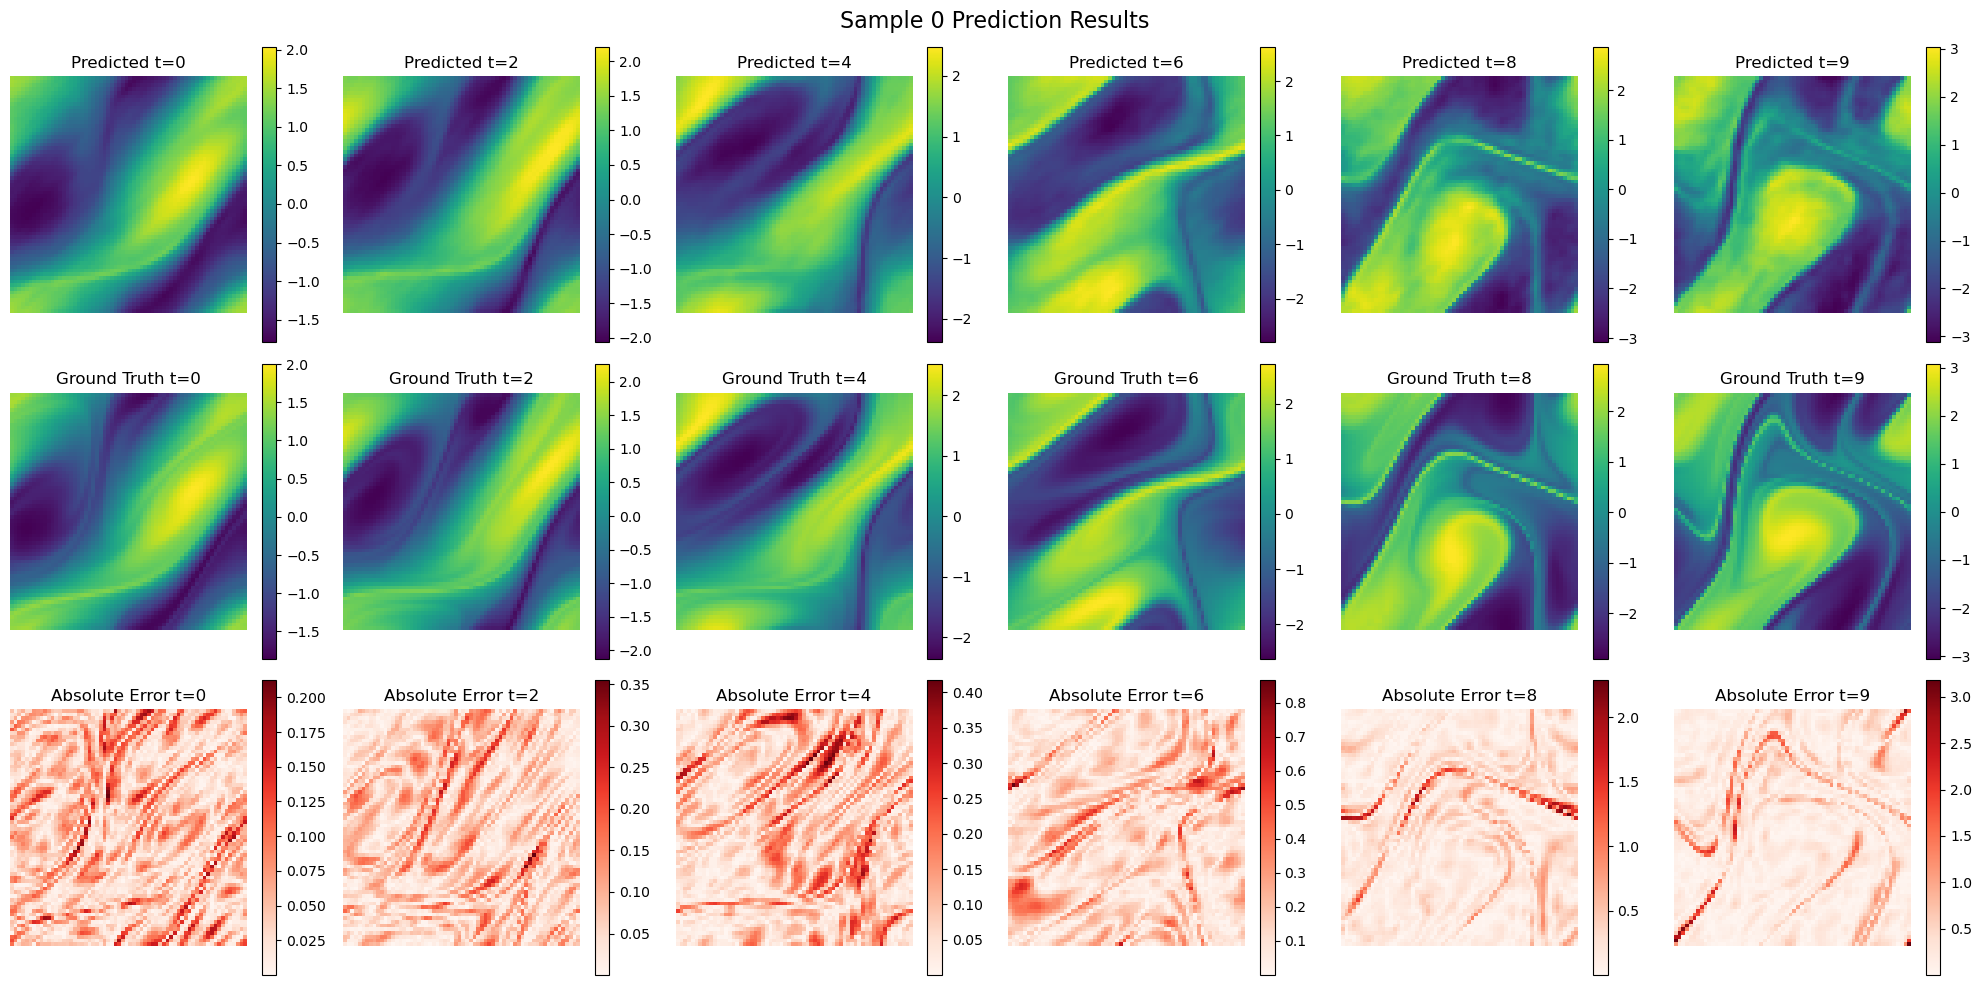

Sample 1 L2 Error: 1.2759e-01


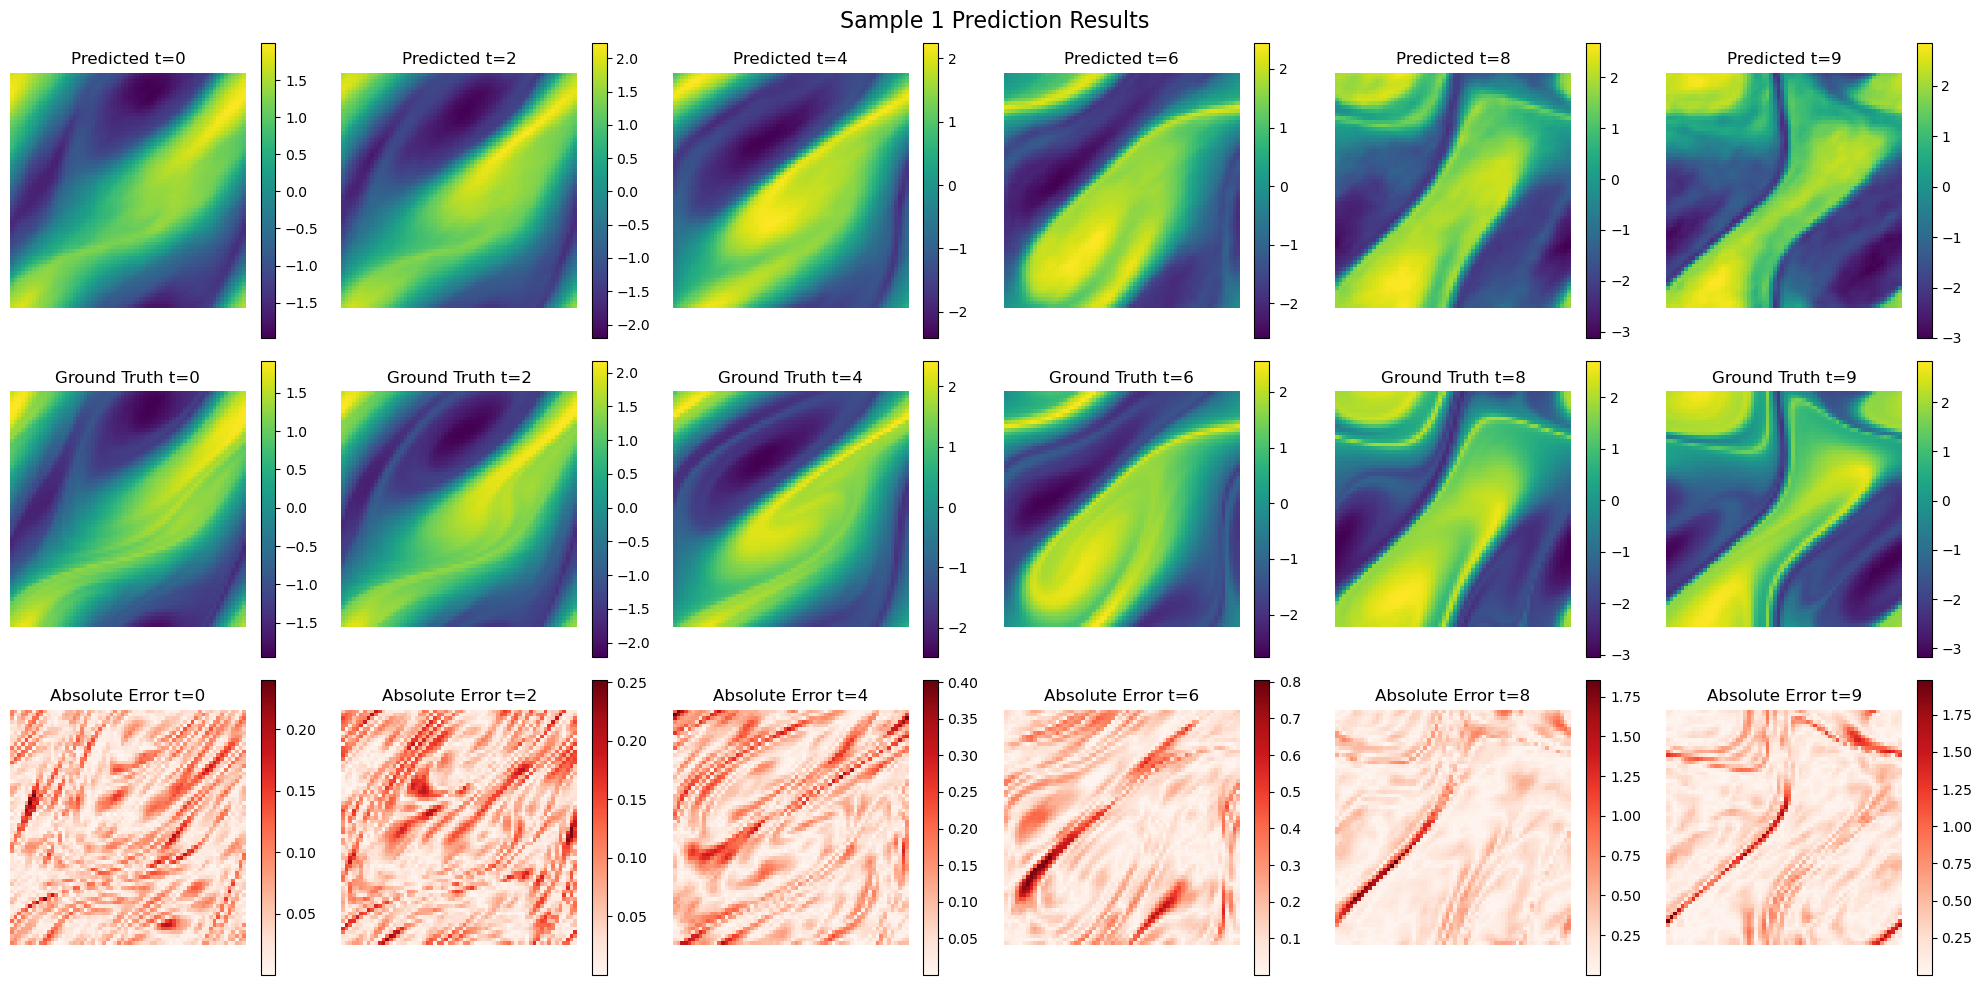

Sample 2 L2 Error: 1.7643e-01


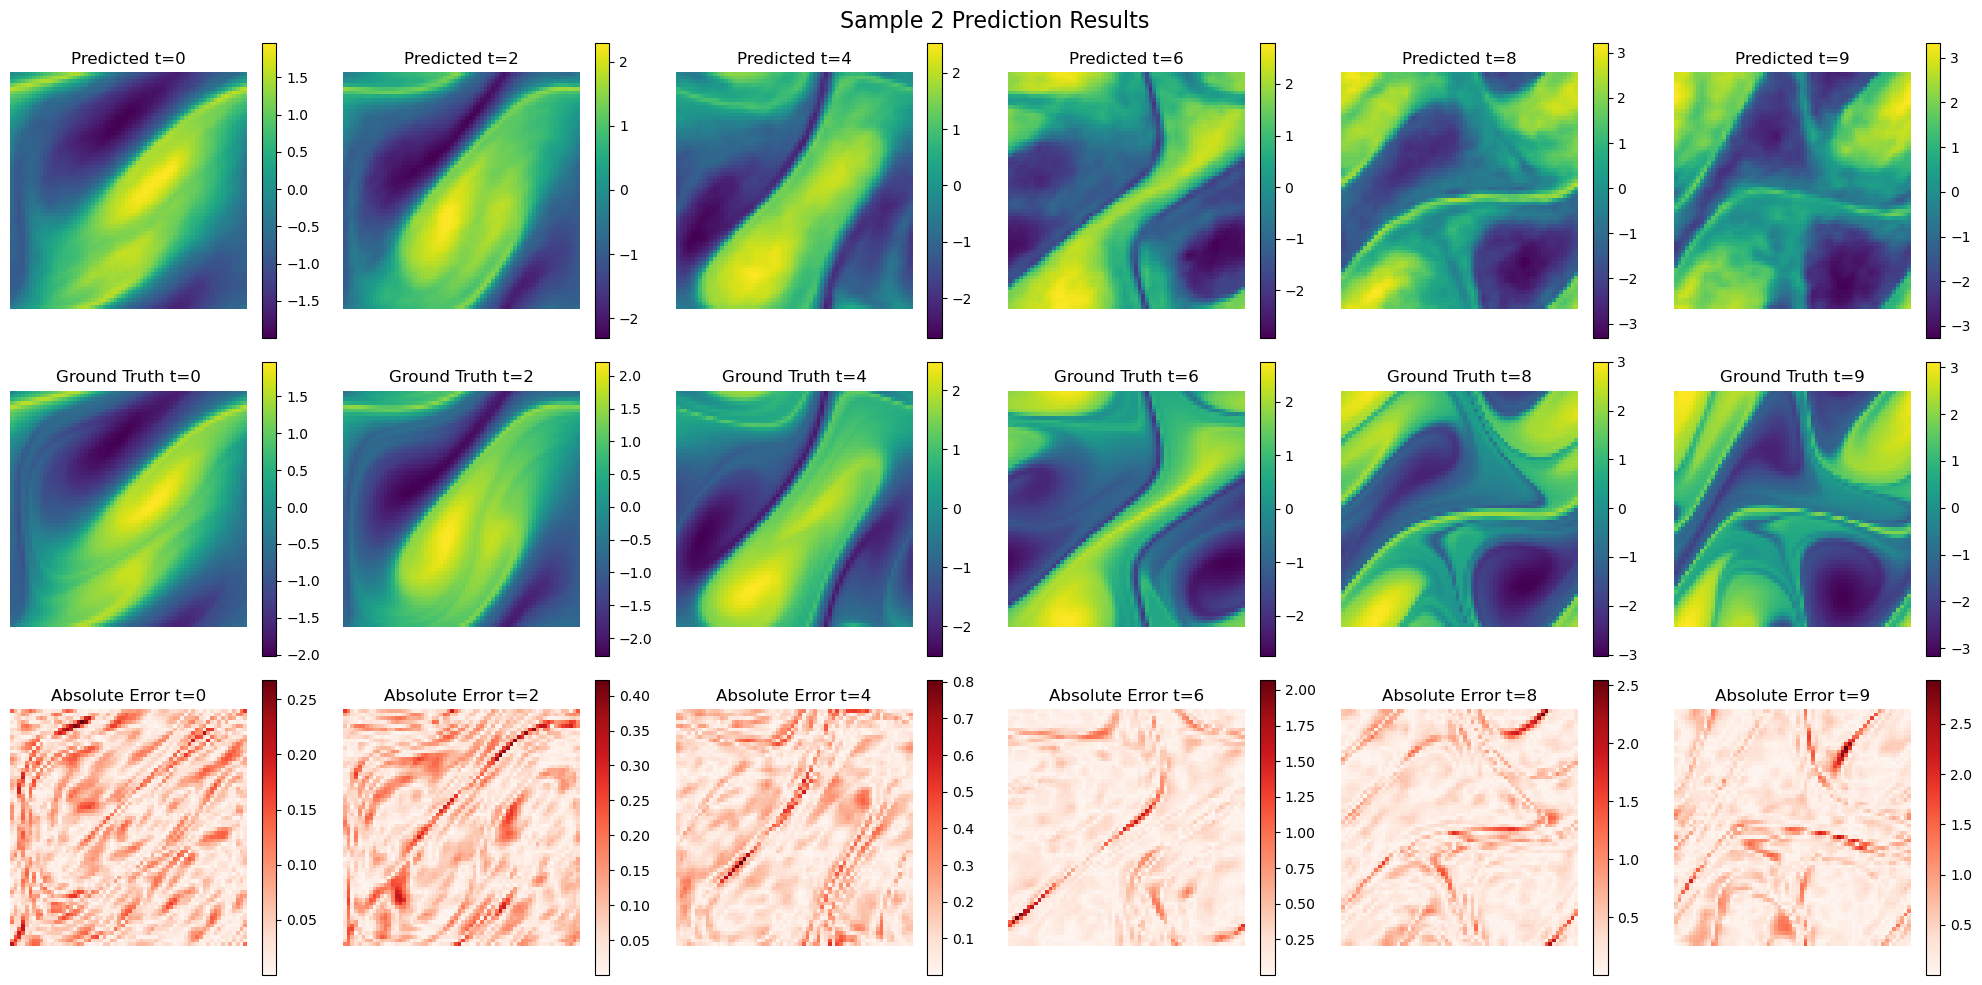


预测结果已保存到: pred/ns_fourier_2d_rnn_V1e-5_T20_N1000_ep500_m12_w20.mat
可视化图片已保存到: image/ns_fourier_2d_rnn_V1e-5_T20_N1000_ep500_m12_w20/

整体预测统计:
整体 L2 相对误差: 0.457155
处理样本数: 3

各样本相对误差详情:
样本 0: 0.153132
样本 1: 0.127589
样本 2: 0.176434


In [14]:
################################################################
# 模型预测和可视化
################################################################

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)

pred = torch.zeros_like(test_u)
index = 0
processed_samples = []  # 存储实际处理的样本

print("开始预测和可视化...")

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        xx = x.clone()
        preds = []

        # 滚动预测 T 个时间步
        for t in range(T):
            im = model(xx)  # 输出 t 时刻
            preds.append(im)

            # 更新输入
            xx = torch.cat((xx[..., 1:-2], im, gridx.repeat([1, 1, 1, 1]), gridy.repeat([1, 1, 1, 1])), dim=-1)

        # 拼接 T 个预测 [1, 64, 64, T]
        out = torch.cat(preds, dim=-1)
        pred[index] = out

        test_l2 = myloss(out.reshape(1, -1), y.reshape(1, -1)).item()
        print(f"Sample {index} L2 Error: {test_l2:.4e}")

        # ===== 改进的可视化对比 =====
        if index < 3:  # 只可视化前3个样本
            # 选择要显示的时间步
            time_steps_to_show = [0, 2, 4, 6, 8, 9]
            
            fig, axes = plt.subplots(3, len(time_steps_to_show), figsize=(20, 10))
            
            for i, t_vis in enumerate(time_steps_to_show):
                # 预测值
                im1 = axes[0, i].imshow(out[0, :, :, t_vis].cpu(), cmap='viridis')
                axes[0, i].set_title(f'Predicted t={t_vis}')
                axes[0, i].axis('off')
                plt.colorbar(im1, ax=axes[0, i])
                
                # 真实值
                im2 = axes[1, i].imshow(y[0, :, :, t_vis].cpu(), cmap='viridis')
                axes[1, i].set_title(f'Ground Truth t={t_vis}')
                axes[1, i].axis('off')
                plt.colorbar(im2, ax=axes[1, i])
                
                # 误差
                error = torch.abs(out[0, :, :, t_vis] - y[0, :, :, t_vis]).cpu()
                im3 = axes[2, i].imshow(error, cmap='Reds')
                axes[2, i].set_title(f'Absolute Error t={t_vis}')
                axes[2, i].axis('off')
                plt.colorbar(im3, ax=axes[2, i])
                
                # 计算相对误差 (只打印一次)
                if index == 0:  # 只在第一个样本时打印列标题
                    rel_error = torch.norm(error) / torch.norm(y[0, :, :, t_vis].cpu())
                    print(f"样本 {index} 时间步 {t_vis} 相对误差: {rel_error:.6f}")

            plt.suptitle(f'Sample {index} Prediction Results', fontsize=16)
            plt.tight_layout()
            # 保存图片
            plt.savefig(os.path.join(path_image, f'sample{index}_complete_comparison.png'), dpi=150, bbox_inches='tight')
            plt.show()
            
            # 存储已处理的样本
            processed_samples.append((out.cpu(), y.cpu()))

        index += 1
        
        # 只处理前几个样本以节省时间
        if index >= 3:
            break

# 保存预测结果 (只保存实际处理的样本)
if len(processed_samples) > 0:
    # 创建包含实际处理样本的预测结果
    processed_pred = torch.stack([sample[0].squeeze() for sample in processed_samples])
    processed_true = torch.stack([sample[1].squeeze() for sample in processed_samples])
    
    scipy.io.savemat(f'pred/{path}.mat', mdict={'pred': processed_pred.numpy()})
    print(f"\n预测结果已保存到: pred/{path}.mat")
    print(f"可视化图片已保存到: {path_image}/")

    # 计算整体统计 (使用 reshape 而不是 view)
    print(f"\n整体预测统计:")
    overall_error = myloss(processed_pred.reshape(processed_pred.shape[0], -1), 
                          processed_true.reshape(processed_true.shape[0], -1)).item()
    print(f"整体 L2 相对误差: {overall_error:.6f}")
    print(f"处理样本数: {len(processed_samples)}")
    
    # 打印每个样本的详细相对误差
    print(f"\n各样本相对误差详情:")
    for i, (pred_sample, true_sample) in enumerate(processed_samples):
        sample_error = myloss(pred_sample.reshape(1, -1), true_sample.reshape(1, -1)).item()
        print(f"样本 {i}: {sample_error:.6f}")
else:
    print("没有处理任何样本！")

In [15]:
################################################################
# 实验总结
################################################################

print("=" * 60)
print("FNO 模型训练和预测实验总结")
print("=" * 60)
print(f"模型参数: modes={modes}, width={width}")
print(f"训练配置: epochs={epochs}, batch_size={batch_size}, lr={learning_rate}")
print(f"数据配置: 训练样本={ntrain}, 测试样本={ntest}, 分辨率={S}x{S}")
print(f"时间配置: 输入时间步={T_in}, 预测时间步={T}")
print("-" * 60)

if len(train_losses) > 0:
    print(f"最终训练损失 (步进): {train_step_losses[-1]:.6f}")
    print(f"最终训练损失 (全序列): {train_full_losses[-1]:.6f}")
    print(f"最终测试损失 (步进): {test_step_losses[-1]:.6f}")
    print(f"最终测试损失 (全序列): {test_full_losses[-1]:.6f}")
    print(f"平均训练时间: {np.mean(times):.2f} 秒/epoch")

print("-" * 60)
print("实验完成！手动实现的 FNO 模型成功求解了 2D Navier-Stokes 方程")
print("=" * 60)

FNO 模型训练和预测实验总结
模型参数: modes=12, width=20
训练配置: epochs=500, batch_size=20, lr=0.0025
数据配置: 训练样本=1000, 测试样本=200, 分辨率=64x64
时间配置: 输入时间步=10, 预测时间步=10
------------------------------------------------------------
最终训练损失 (步进): 0.082841
最终训练损失 (全序列): 0.095674
最终测试损失 (步进): 0.113929
最终测试损失 (全序列): 0.138178
平均训练时间: 9.77 秒/epoch
------------------------------------------------------------
实验完成！手动实现的 FNO 模型成功求解了 2D Navier-Stokes 方程


## 模型预测和可视化

对测试集进行预测，并可视化预测结果、真实值和误差。每个样本显示：
- **第一行**: 模型预测值
- **第二行**: 真实值  
- **第三行**: 绝对误差

使用 `viridis` 颜色映射以提供更好的视觉效果。